In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
from datetime import timedelta
import pathlib
import matplotlib.pyplot as plt

In [2]:
def parse_iso8601_duration(duration):
    try:
        # Regular expression for matching ISO 8601 duration format (P[n]Y[n]M[n]DT[n]H[n]M[n]S)
        match = re.match(r'P(?:(\d+)Y)?(?:(\d+)M)?(?:(\d+)D)?T?(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', duration)
        
        if not match:
            raise ValueError("Invalid ISO 8601 duration format")
    
        years, months, days, hours, minutes, seconds = match.groups()
        
        # Convert parts to integers or 0 if not provided
        years = int(years or 0)
        months = int(months or 0)
        days = int(days or 0)
        hours = int(hours or 0)
        minutes = int(minutes or 0)
        seconds = int(seconds or 0)
        
        # Approximate a duration in days using years and months
        # Note: This is a simple approximation. A more complex calculation can be done if needed
        days += years * 365 + months * 30  # Assumes 30 days in a month for approximation
        
        # Return a timedelta object
        return days
    except:
        return None
duration = "P2Y3M4DT5H6M7S"
parsed_duration = parse_iso8601_duration(duration)
print(parsed_duration)

824


In [3]:
plot_path = pathlib.Path("../figs")
datapath = pathlib.Path("../data/reports")

In [4]:
df = pd.read_csv(datapath / "durations_fines.csv")

In [5]:
df.head()

,AppealId,AppealDecision,PunishmentDuration,FineAmount,CurrencyCode
0,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P0D,0.0,EUR
1,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P1Y,0.0,EUR
2,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P2Y,0.0,EUR
3,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P0D,18620.0,EUR
4,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P1Y,18620.0,EUR


In [6]:
df["punishement [days]"] = df.PunishmentDuration.apply(lambda x: x if x is None else parse_iso8601_duration(x))

In [7]:
sum(df["punishement [days]"].isnull()), sum(~df["punishement [days]"].isnull())

(1317, 8553)

In [8]:
df.AppealDecision.value_counts().head()

AppealDecision
http://growgraph.dev/fcaont#AppealRejected                                   5370
http://growgraph.dev/fcaont#AppealPartiallyUpheld                            1586
http://growgraph.dev/fcaont#AppealCassationPartial                             51
http://growgraph.dev/fcaont#AppealUpheld                                       47
https://growgraph.dev/fca/appeal/fca--22-84--985#AppealDecision_22_84_985      43
Name: count, dtype: int64

In [9]:
df["decision"] = df.AppealDecision.replace({"http://growgraph.dev/fcaont#AppealRejected": "AppealRejected"})
df.loc[df["decision"] != "AppealRejected", "decision"] = "Upheld"

In [10]:
df.head()

,AppealId,AppealDecision,PunishmentDuration,FineAmount,CurrencyCode,punishement [days],decision
0,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P0D,0.0,EUR,0.0,AppealRejected
1,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P1Y,0.0,EUR,365.0,AppealRejected
2,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P2Y,0.0,EUR,730.0,AppealRejected
3,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P0D,18620.0,EUR,0.0,AppealRejected
4,16-82.525,http://growgraph.dev/fcaont#AppealRejected,P1Y,18620.0,EUR,365.0,AppealRejected


In [11]:
df2 = df.loc[df["punishement [days]"].notnull() & (df["punishement [days]"] > 0) & (df["punishement [days]"] < 6000)].copy()
df2 = df2.drop_duplicates(["AppealId", "punishement [days]"])
df2.head()
df2.shape

(723, 7)

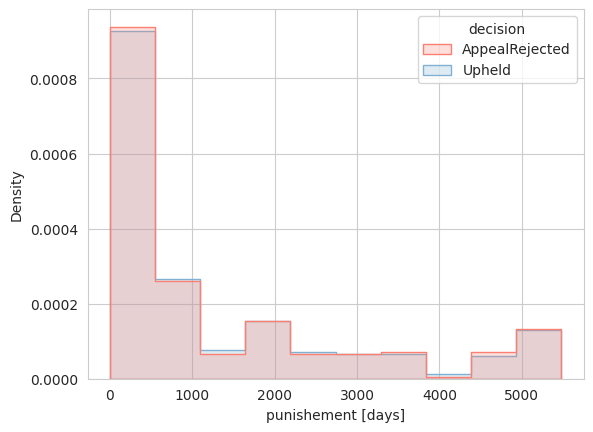

In [12]:
sns.set_style("whitegrid")
qualitative_colors = sns.color_palette("Set3", 10)[3:5]
hue_order = sorted(df2["decision"].unique())
sns.histplot(df2, x="punishement [days]", hue="decision", 
             common_norm=False, stat="density", element="step", bins=10, hue_order=hue_order,
            palette=qualitative_colors)
plt.savefig(
    plot_path.expanduser() / "custodial_duration.png",
    dpi=300,
    bbox_inches="tight",
)

In [13]:
df2.decision.value_counts()/df2.shape[0]

decision
AppealRejected    0.573997
Upheld            0.426003
Name: count, dtype: float64

In [14]:
df3 = df.loc[df["FineAmount"].notnull() & (df["FineAmount"] > 1) & (df["FineAmount"] < 1e7)].copy().rename(columns={"FineAmount": "Fine [euro]"})
df3 = df3.drop_duplicates(["AppealId", "Fine [euro]"])
df3.shape

(444, 7)

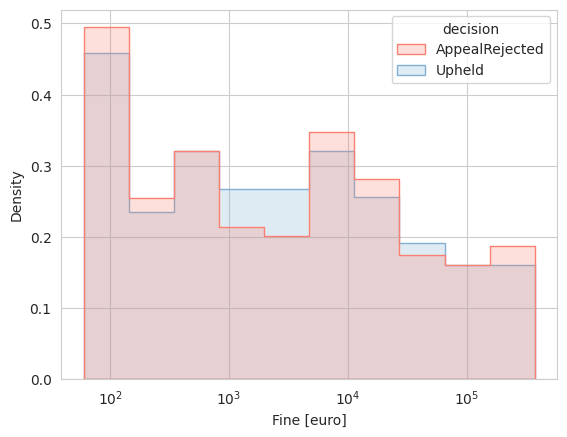

In [15]:
qualitative_colors = sns.color_palette("Set3", 10)[3:5]
sns.histplot(df3, x="Fine [euro]", hue="decision", 
             common_norm=False, stat="density", element="step", 
             palette=qualitative_colors,
             hue_order=hue_order,
             # bins=10,
             log_scale=True,
            )

plt.savefig(
    plot_path.expanduser() / "fines.png",
    dpi=300,
    bbox_inches="tight",
)

In [16]:
df = pd.read_csv(datapath / "offense_vc.csv")
# df["decision"] = df.AppealDecision.replace({"http://growgraph.dev/fcaont#AppealRejected": "AppealRejected"})
# df.loc[df["decision"] != "AppealRejected", "decision"] = "Upheld"
df["Offense Type"] = df.offenseType.apply(lambda x: x.split("#")[-1])
df.head()

,offenseType,count,Offense Type
0,http://growgraph.dev/fcaont#ViolentOffense,537,ViolentOffense
1,http://growgraph.dev/fcaont#PropertyOffense,264,PropertyOffense
2,http://growgraph.dev/fcaont#PublicOrderCrime,262,PublicOrderCrime
3,http://growgraph.dev/fcaont#DrugOffense,239,DrugOffense
4,http://growgraph.dev/fcaont#Fraud,232,Fraud


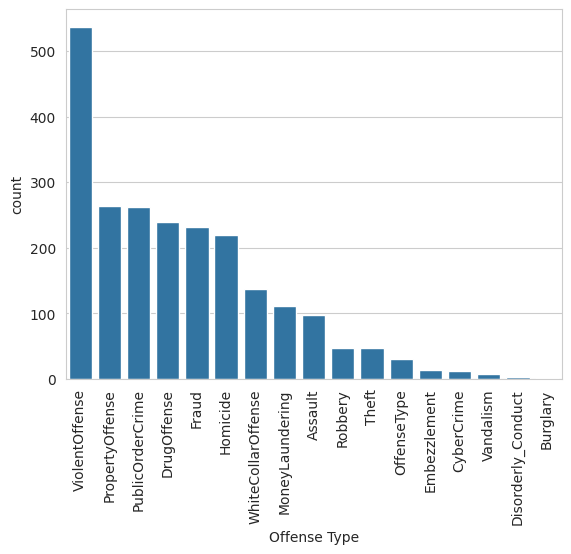

In [17]:
sns.set_style("whitegrid")
ax = sns.barplot(df, x="Offense Type", y="count")
ax.tick_params(axis="x", rotation=90)

plt.savefig(
    plot_path.expanduser() / "offense_type.png",
    dpi=300,
    bbox_inches="tight",
)

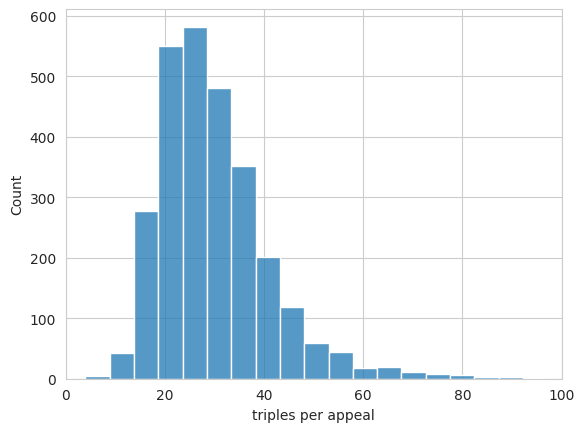

In [18]:
sns.set_style("whitegrid")
df = pd.read_csv(datapath / "triple_count.csv").rename(columns={"tripleCount": "triples per appeal"})
ax = sns.histplot(df["triples per appeal"], bins=30)
ax.set_xlim([0, 100])
plt.savefig(
    plot_path.expanduser() / "triples.png",
    dpi=300,
    bbox_inches="tight",
)

In [19]:
df["triples per appeal"].mean()

30.001077586206897